# Term Deposit Subscription Prediction and Client Targeting

This project focuses on predicting which customers are most likely to subscribe to a term deposit and providing actionable recommendations for client outreach. A **term deposit** is a secure financial product where a customer deposits a fixed sum of money for a predetermined period, earning a guaranteed interest rate. It is commonly used by individuals seeking low-risk investment options with stable returns.

To support the marketing team in prioritizing client engagement, the project leverages data analysis and machine learning to identify users with the highest likelihood of subscribing. The goal is to build a reliable prediction pipeline that can guide business decisions and improve the efficiency of customer targeting strategies.

The steps taken in this project include:
- **Exploratory Data Analysis (EDA)** to understand patterns and insights from the dataset.
- **Machine Learning model development** to classify potential subscribers based on customer attributes.
- Use of **predicted probabilities** to assess the model's confidence in each prediction.
- **Target selection based on probability thresholds** to isolate high-confidence leads.
- **Data filtering using DuckDB**, enabling fast and flexible querying of large datasets within the notebook environment.
- **Clustering techniques** such as **K-Means** and **Hierarchical Clustering** to segment customers into meaningful groups.
- **Dimensionality reduction and visualization** using **UMAP**, **PCA**, and **t-SNE** to gain intuitive insights into the customer landscape.

Together, these steps form a complete end-to-end pipeline to not only predict potential term deposit subscribers but also to present the results in a way that is interpretable and actionable for business stakeholders.


In [206]:
#Importing Required Libraries for pandas and visualization
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir(r'C:\Users\Ralph Dawang\Documents\Apziva Mentoring - ML\Project 2')

df = pd.read_csv('term-deposit-marketing-2020.csv')

In [207]:
# Importing Libraries for ML model and Evaluation Tools
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.svm import SVC
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
import xgboost as xgb
import lightgbm as lgb
import random

# Exploratory Data Analysis (EDA)

This process will help in analyzing and visualizing the data to get more insights which we will use to correlate once we come to Machine Learning part

## Univariate Analysis

This section focuses on analyzing individual variables to understand their underlying distribution, central tendency, and spread. Univariate analysis helps in summarizing each variable independently using statistical measures such as mean, median, mode, and standard deviation, along with visualizations like histograms, box plots, and bar charts. The goal is to gain a clear understanding of the structure and behavior of each feature in the dataset before exploring relationships between them.

In [208]:
#Overview of the dataset showing the first 5 data.

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [209]:
#Checking the number of data in columns x rows

df.shape

(40000, 14)

In [210]:
#Checking the data types of the variables

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [211]:
#Validating if there are columns with no values

df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [212]:
# For each column, count how many times 'unknown' appears
unknown_counts = (df == 'unknown').sum()

# Show only columns where 'unknown' actually exists
unknown_counts = unknown_counts[unknown_counts > 0]

print(unknown_counts)

job            235
education     1531
contact      12765
dtype: int64


From the all the dataset, there are "unknown" values found and we can see how many unknown values are present for each feature. Given that the contact is almost 32% of the overall data, we will not be dropping the unknown values and will treat it as a data.

In [213]:
#Identifying the header columns of the dataset
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y'],
      dtype='object')

In [214]:
#Renaming y into subscribed for much clearer description
df.rename(columns={'y': 'subscribed'}, inplace=True)

In [215]:
#revalidating the column header of our dataset
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'subscribed'],
      dtype='object')

In [216]:
# Checking how many clients has subscribed or not from the given dataset
df['subscribed'].value_counts()

subscribed
no     37104
yes     2896
Name: count, dtype: int64

In [217]:
#Specifying the subscribed count in terms of percentage
df['subscribed'].value_counts(normalize=True)

subscribed
no    0.93
yes   0.07
Name: proportion, dtype: float64

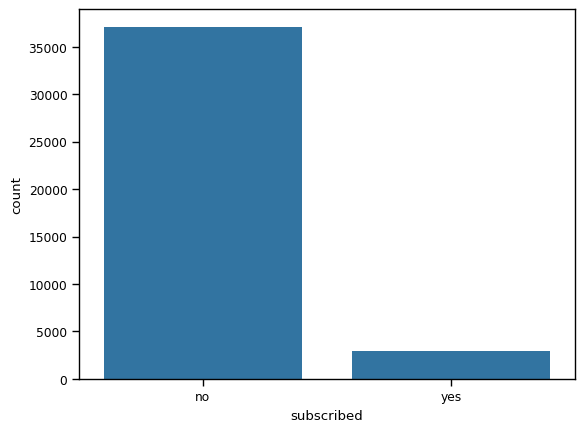

In [218]:
#Plotting the subscribed column for visualization
sns.countplot(data=df, x = 'subscribed')
plt.show()

From the initial findings for subscribed data, we can see that we have a total of 40,000 data where 
37,104 (93%) didn't subscribe compared to 2896 (7%) who subscribed for term deposit

Overall, we can confirm that we have an imbalance dataset.

In [219]:
df['job'].value_counts()

job
blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: count, dtype: int64

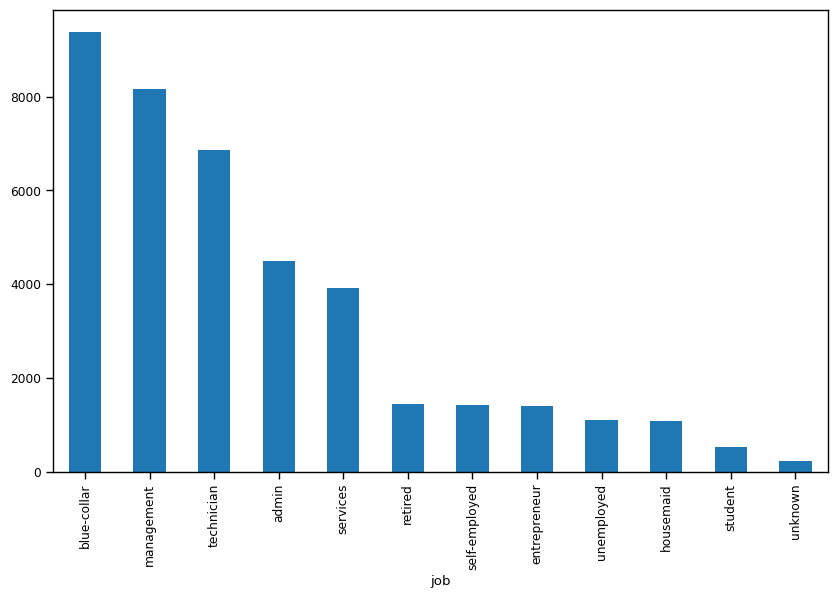

In [220]:
sns.set_context('paper')
df['job'].value_counts().plot(kind='bar', figsize=(10,6));

From the data, we can see that most of the clients are having blue-collar or management job where student is the least to make a term deposit

In [221]:
df['age'].value_counts()

age
32    1909
31    1826
33    1770
34    1730
35    1721
      ... 
90       1
94       1
86       1
95       1
81       1
Name: count, Length: 70, dtype: int64

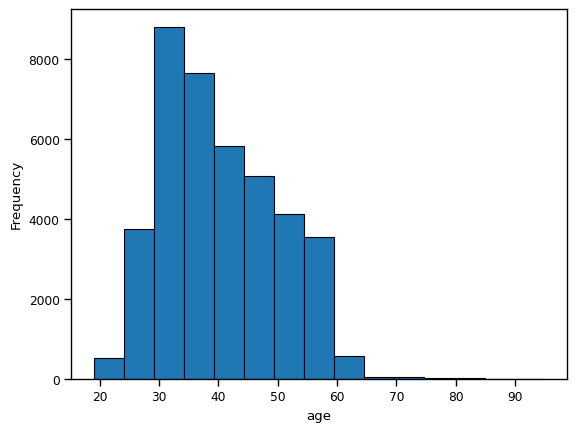

In [222]:
df['age'].plot(kind='hist', bins=15, edgecolor='black')
plt.xlabel('age')
plt.show()

Data shows that the group age is between 20 to 60 years old.

In [223]:
df['marital'].value_counts()

marital
married     24386
single      10889
divorced     4725
Name: count, dtype: int64

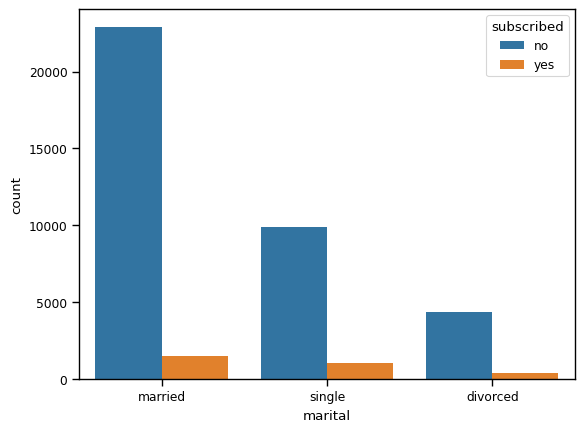

In [224]:
sns.countplot(data=df, x='marital', hue='subscribed', stat='count');

We can see that majority of the clients from the data are married compared to the number of single and divorced.

## Bivariate Analysis

This section explores the relationship between two variables to identify any underlying patterns, trends, or associations. Through bivariate analysis, the presenter aims to highlight how variables interact with each other, using visual tools like scatter plots and statistical techniques such as correlation. This approach provides deeper insights into the dataset beyond what can be observed from individual variables alone.

In [225]:
pd.crosstab(df['job'], df['subscribed'])

subscribed,no,yes
job,,
admin,4132,351
blue-collar,8848,535
entrepreneur,1317,88
housemaid,1034,53
management,7490,676
retired,1286,151
self-employed,1302,112
services,3672,238
student,442,82


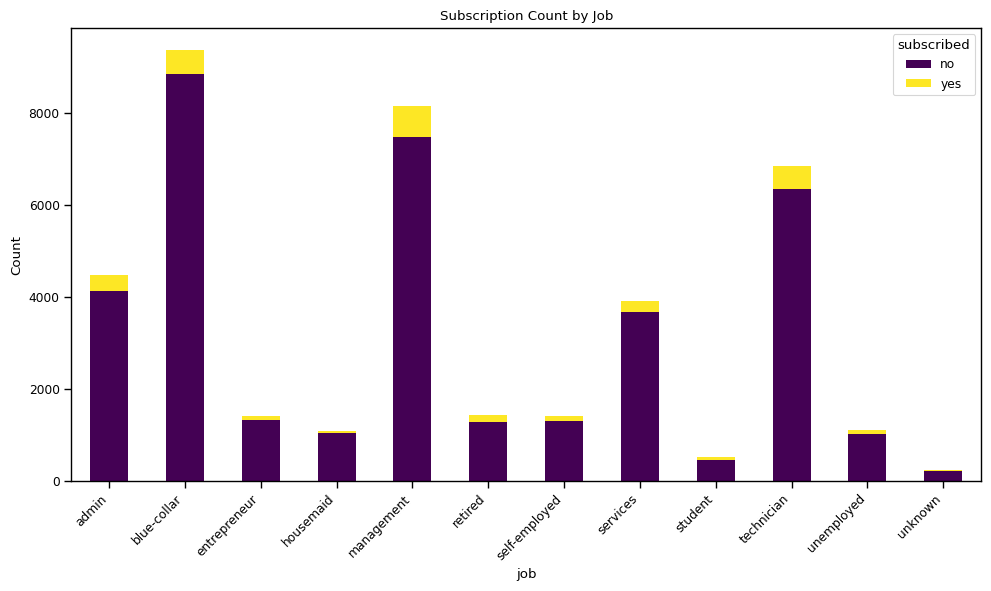

In [226]:
pd.crosstab(df['job'], df['subscribed']).plot(kind='bar', stacked=True, figsize=(10,6), colormap='viridis')
plt.title('Subscription Count by Job')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

From the comparison of job and if they have subscribed, we can see that majority who subscribed are working in blue-collar, management, or technician role.

In [227]:
pd.crosstab(df['education'], df['subscribed'])

subscribed,no,yes
education,,
primary,5917,353
secondary,19575,1418
tertiary,10177,1029
unknown,1435,96


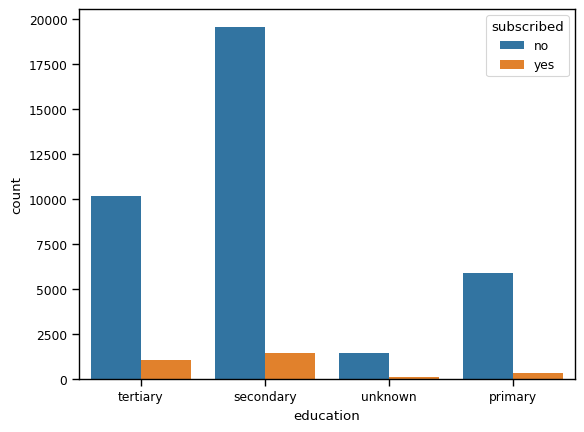

In [228]:
sns.countplot(data=df, x='education', hue='subscribed', stat='count');

In [229]:
pd.crosstab(df['marital'], df['subscribed'])

subscribed,no,yes
marital,,
divorced,4334,391
married,22908,1478
single,9862,1027


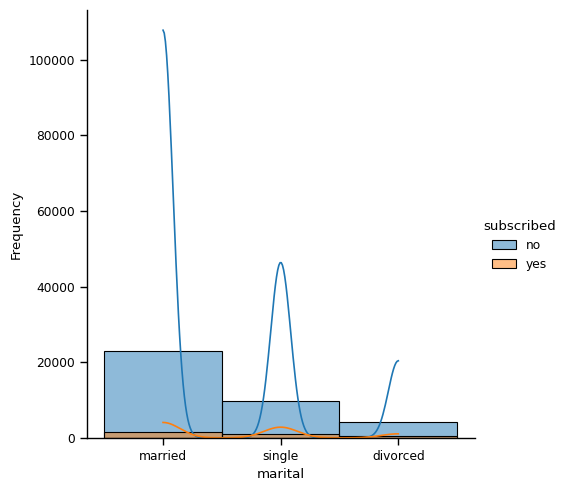

In [230]:
sns.FacetGrid(df, hue="subscribed", height=5).map(sns.histplot, "marital", kde=True).add_legend()
plt.xlabel('marital')
plt.ylabel('Frequency')
plt.show()

In terms of overall percentage, we can infer that single clients most likely to subscribe to term deposit. It's just that the data has a large number of married clients but looking at the numbers, married are less likely to subscribe

In [231]:
pd.crosstab(df['housing'], df['subscribed'])

subscribed,no,yes
housing,,
no,14537,1432
yes,22567,1464


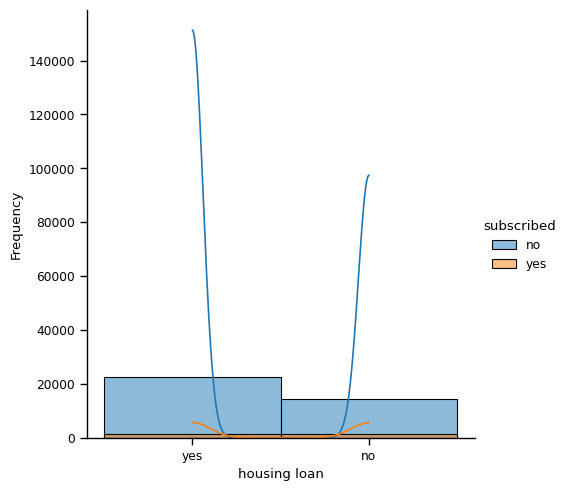

In [232]:
sns.FacetGrid(df, hue="subscribed", height=5).map(sns.histplot, "housing", kde=True).add_legend()
plt.xlabel('housing loan')
plt.ylabel('Frequency')
plt.show()

We can infer that most like to subscribe to term deposit are clients with no current housing loan.

In [233]:
pd.crosstab(df['loan'], df['subscribed'])

subscribed,no,yes
loan,,
no,30554,2516
yes,6550,380


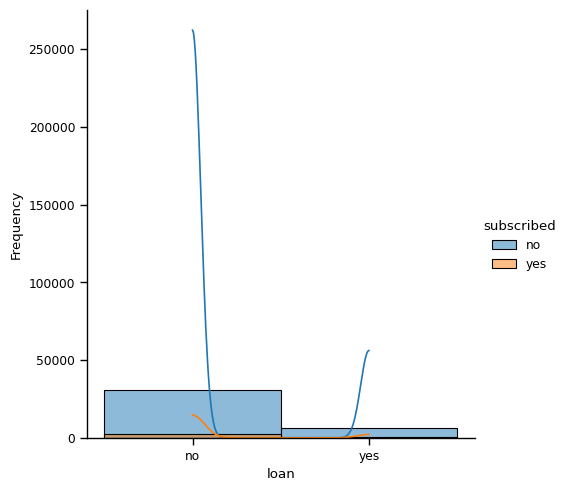

In [234]:
sns.FacetGrid(df, hue="subscribed", height=5).map(sns.histplot, "loan", kde=True).add_legend()
plt.xlabel('loan')
plt.ylabel('Frequency')
plt.show()

Overall percentage shows that with or without existing loan, clients can subscribe to term deposit if they like.

In [235]:
pd.crosstab(df['balance'], df['subscribed'])

subscribed,no,yes
balance,,
-8019,1,0
-6847,1,0
-4057,1,0
-3372,1,0
-3313,1,0
...,...,...
64343,1,0
66653,1,0
66721,1,0


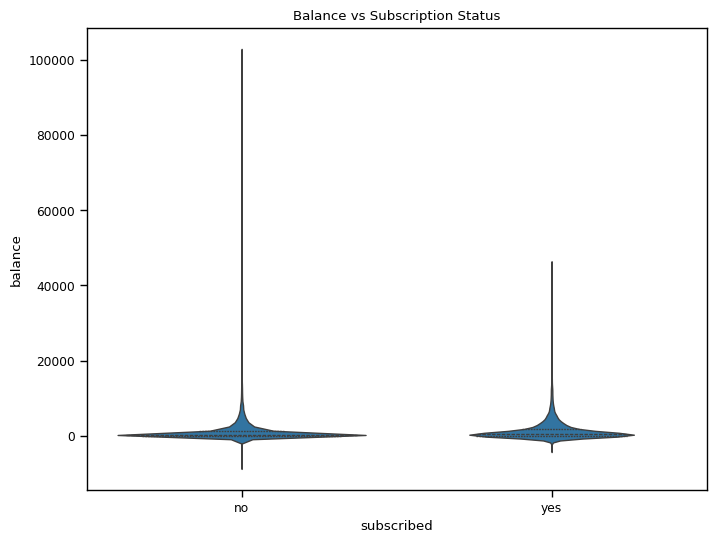

In [236]:
plt.figure(figsize=(8,6))
sns.violinplot(x='subscribed', y='balance', data=df, inner="quartile")
plt.title('Balance vs Subscription Status')
plt.show()

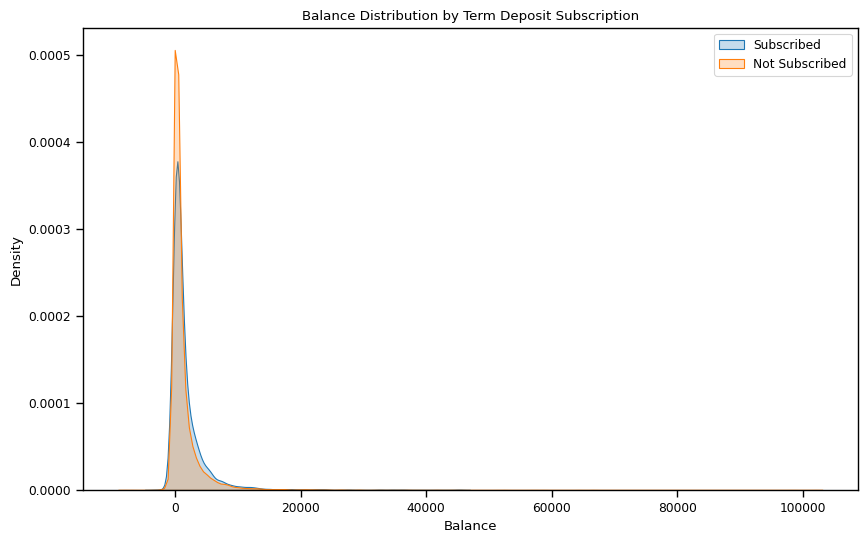

In [237]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=df[df['subscribed']=='yes'], x='balance', label='Subscribed', fill=True)
sns.kdeplot(data=df[df['subscribed']=='no'], x='balance', label='Not Subscribed', fill=True)
plt.xlabel('Balance')
plt.ylabel('Density')
plt.title('Balance Distribution by Term Deposit Subscription')
plt.legend()
plt.show()

From the data and graphs, we can infere that majority of subscribers came from individual with low balances

In [238]:
pd.crosstab(df['day'], df['subscribed'])

subscribed,no,yes
day,,
1,136,40
2,1005,104
3,794,80
4,1066,117
5,1578,113
6,1668,110
7,1532,80
8,1518,102
9,1302,72


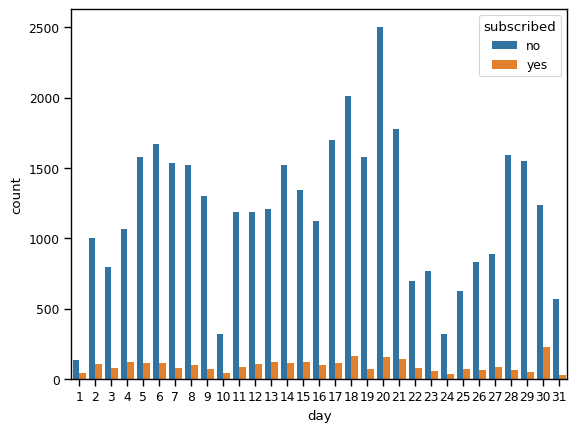

In [239]:
sns.countplot(data=df, x='day', hue='subscribed', stat='count');

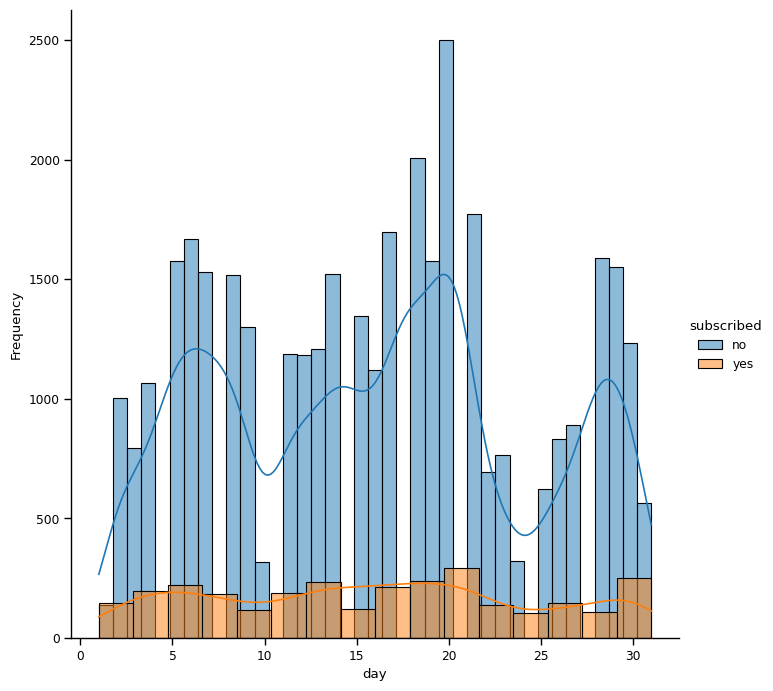

In [240]:
sns.FacetGrid(df, hue="subscribed", height=7).map(sns.histplot, "day", kde=True).add_legend()
plt.xlabel('day')
plt.ylabel('Frequency')
plt.show()

Most clients who subscribe to term deposit have been contacted by 20th of the month

In [241]:
pd.crosstab(df['month'], df['subscribed'])

subscribed,no,yes
month,,
apr,2267,451
aug,4927,288
dec,12,1
feb,2041,255
jan,1138,38
jul,5996,384
jun,4440,294
mar,133,125
may,12741,791


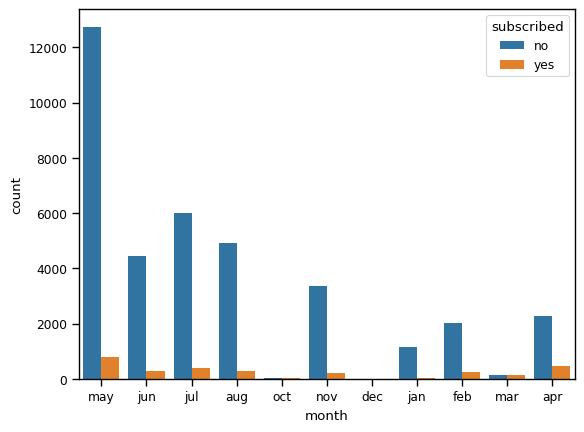

In [242]:
sns.countplot(data=df, x='month', hue='subscribed', stat='count');

From the above graph, we can observe that most clients subscribe to term deposit for the month of april.

In [243]:
pd.crosstab(df['duration'], df['subscribed'])

subscribed,no,yes
duration,,
0,3,0
1,1,0
2,3,0
3,4,0
4,5,0
...,...,...
3322,1,0
3366,1,0
3422,1,0


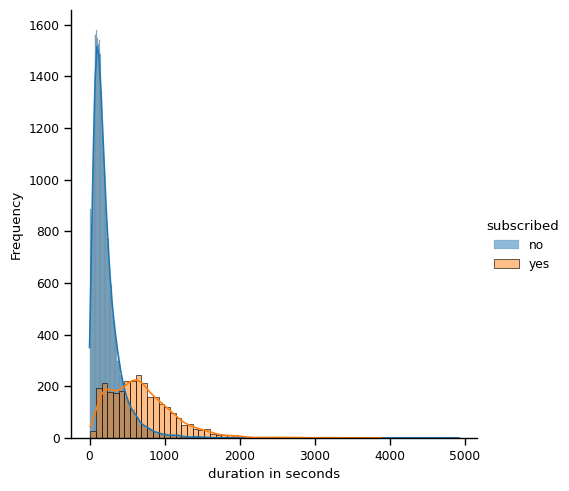

In [244]:
sns.FacetGrid(df, hue="subscribed", height=5).map(sns.histplot, "duration", kde=True).add_legend()
plt.xlabel('duration in seconds')
plt.ylabel('Frequency')
plt.show()

Average call time in seconds of those who subscribed are in the range of 100-1000 seconds

In [245]:
pd.crosstab(df['campaign'], df['subscribed'])

subscribed,no,yes
campaign,,
1,13454,1264
2,10393,760
3,4618,352
4,3075,222
5,1547,95
6,1160,68
7,664,35
8,501,25
9,299,19


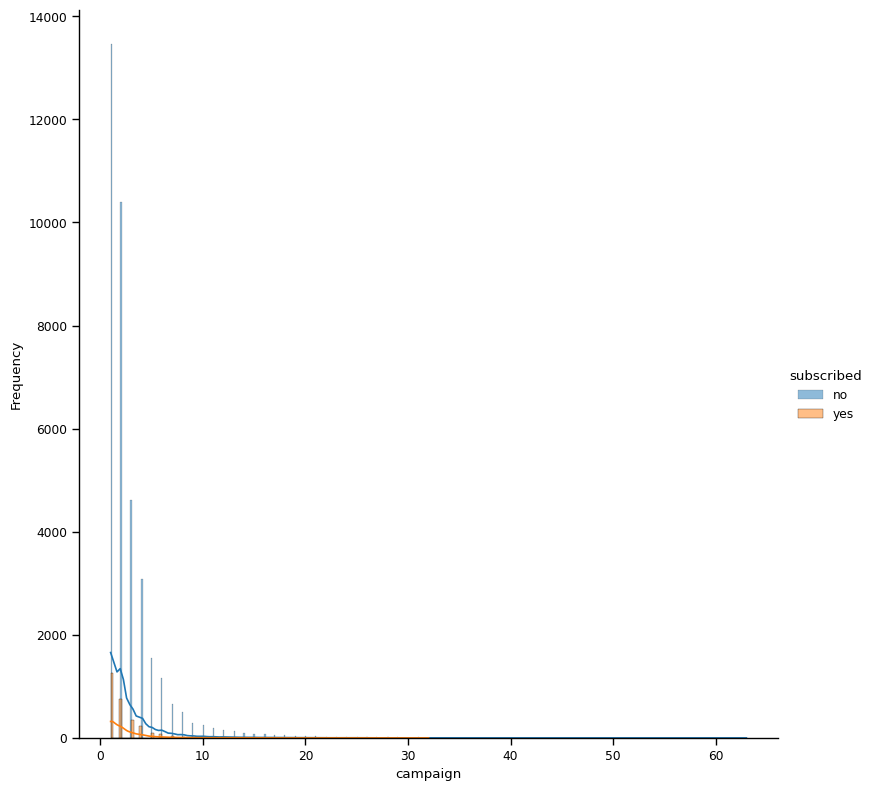

In [246]:
sns.FacetGrid(df, hue="subscribed", height=8).map(sns.histplot, "campaign", kde=True).add_legend()
plt.xlabel('campaign')
plt.ylabel('Frequency')
plt.show()

Number of calls made during this campaign where client subscribed are 1-2 calls

# Machine Learning - Model Building

In this section, the focus is on developing predictive models using machine learning algorithms. The process involves selecting appropriate features, splitting the dataset into training and testing sets, and applying algorithms suited to the problem at hand—whether classification, regression, or clustering. The objective is to train models that can learn from the data and generalize well to unseen data, forming the foundation for evaluation and optimization in later stages.

In [247]:
#seed = random.randint(1000, 9999)
seed = 6925
print(seed)

6925


In [248]:
#Splitting the dataset to and specifying features and target variables
#In this dataset, y is our target variable and other parameters will be our features (based from the output of the previous cell)

X = df.drop('subscribed', axis=1)
y = df['subscribed']

In [249]:
# Combine features and encode (One-Hot Encoding) -- coverting string columns into numerical columns and assigning dummy values
X_transformed = pd.get_dummies(X, drop_first=True)

In [250]:
print(X_transformed)

       age  balance  day  duration  campaign  job_blue-collar  \
0       58     2143    5       261         1            False   
1       44       29    5       151         1            False   
2       33        2    5        76         1            False   
3       47     1506    5        92         1             True   
4       33        1    5       198         1            False   
...    ...      ...  ...       ...       ...              ...   
39995   53      395    3       107         1            False   
39996   30     3340    3       238         3            False   
39997   54      200    3       170         1            False   
39998   34     1047    3       342         1            False   
39999   38     1442    3       113         1            False   

       job_entrepreneur  job_housemaid  job_management  job_retired  ...  \
0                 False          False            True        False  ...   
1                 False          False           False        False

In [251]:
# Initial split: 80% train_val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=seed)

In [252]:
# Second split: 75% train, 25% val (25% of 80% = 20% of total)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=seed)

In [253]:
lr = LogisticRegression(class_weight="balanced", random_state=seed)
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=6925)

                precision    recall  f1-score   support

Not_Subscribed       0.98      0.86      0.92      7449
    Subscribed       0.30      0.82      0.44       551

      accuracy                           0.86      8000
     macro avg       0.64      0.84      0.68      8000
  weighted avg       0.94      0.86      0.89      8000



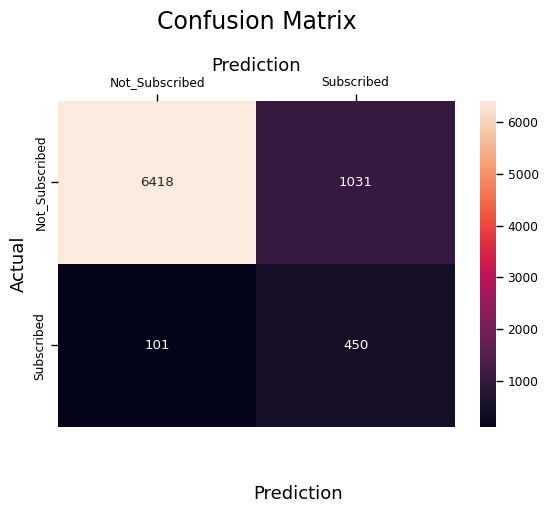

In [254]:
# Evaluating Decision Tree Classifier Performance
# - Generates predictions and computes confusion matrix
# - Displays a classification report for class-wise precision, recall, and F1-score
# - Visualizes confusion matrix using a heatmap

lr_y_pred = lr.predict(X_val)

lr_cm = confusion_matrix(y_val, lr_y_pred)

target_names = ['Not_Subscribed', 'Subscribed']
print(classification_report(y_val, lr_y_pred, target_names=target_names))

sns.heatmap(lr_cm,
            annot=True,
            fmt='g',
            xticklabels=['Not_Subscribed','Subscribed'],
            yticklabels=['Not_Subscribed','Subscribed'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

SUMMARY for validation set:

Multiple Models where tested and resulted to different performance.

LR accuracy = 86% | True Subscriber = 450

LGBM accuracy = 94% | True Subscriber = 237

DTC accuracy = 89% | True Subscriber = 191

BNB accuracy = 93% with data overfitting for Not Subscribed regardless of binarize value

XGBoost accuracy = 94% | True Subscriber = 262

Conclusion:
- For this specific business case, we will use Logistic Regression as our based model as what we require is to find the "Actual / True Subscribers".
- LR provides high recall score which pertains to "True Subscriber"

## Building Model using the original test dataset

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=seed)

In [256]:
lreg = LogisticRegression(class_weight="balanced", random_state=seed)
lreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=6925)

                precision    recall  f1-score   support

Not_Subscribed       0.98      0.84      0.90      7431
    Subscribed       0.27      0.78      0.40       569

      accuracy                           0.84      8000
     macro avg       0.63      0.81      0.65      8000
  weighted avg       0.93      0.84      0.87      8000



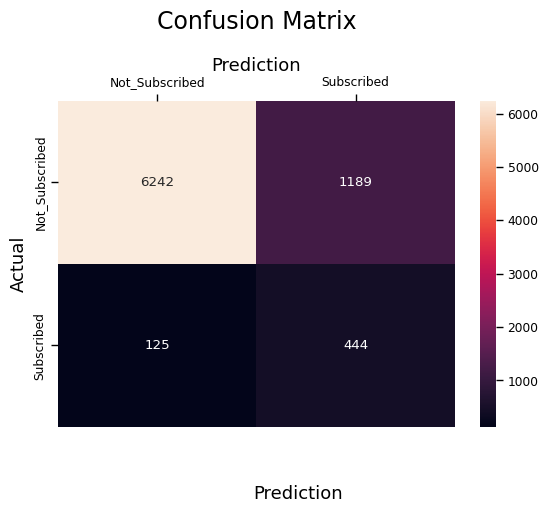

In [257]:
lreg_y_pred = lreg.predict(X_test)

lreg_cm = confusion_matrix(y_test, lreg_y_pred)

target_names = ['Not_Subscribed', 'Subscribed']
print(classification_report(y_test, lreg_y_pred, target_names=target_names))

sns.heatmap(lreg_cm,
            annot=True,
            fmt='g',
            xticklabels=['Not_Subscribed','Subscribed'],
            yticklabels=['Not_Subscribed','Subscribed'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

## Oversampling using SMOTE

In [258]:
#sampling_strategy was not defined as it is clear who is the minority in the the classificiation. 
# By default, auto is selected which pertains to minority

from imblearn.over_sampling import SMOTE

smote=SMOTE(random_state=seed) 

In [259]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [260]:
# shows the total count of the training set
y_train.value_counts()

subscribed
no     29673
yes     2327
Name: count, dtype: int64

In [261]:
# after SMOTE, dataset has been resampled resulting the same data size for both classes.
# SMOTE is used for oversampling the minority class which is in this case -- subscribed (yes)

y_train_smote.value_counts()

subscribed
yes    29673
no     29673
Name: count, dtype: int64

In [262]:
lreg_smote = LogisticRegression(class_weight='balanced', random_state=seed)
lreg_smote.fit(X_train_smote, y_train_smote)

LogisticRegression(class_weight='balanced', random_state=6925)

                precision    recall  f1-score   support

Not_Subscribed       0.96      0.92      0.94      7431
    Subscribed       0.34      0.53      0.41       569

      accuracy                           0.89      8000
     macro avg       0.65      0.72      0.68      8000
  weighted avg       0.92      0.89      0.90      8000



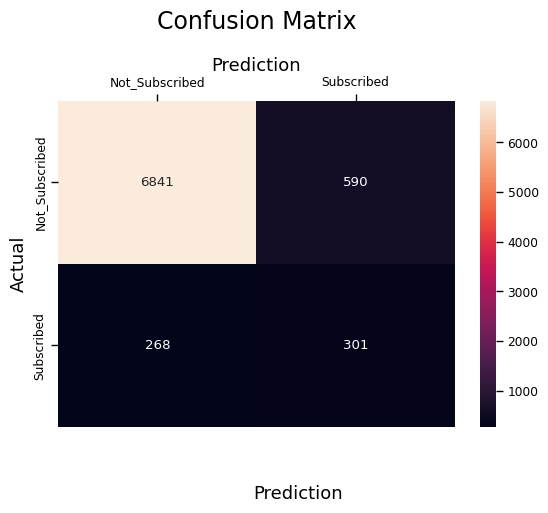

In [263]:
lreg_smote_y_pred = lreg_smote.predict(X_test)

lreg_smote_cm = confusion_matrix(y_test, lreg_smote_y_pred)

target_names = ['Not_Subscribed', 'Subscribed']
print(classification_report(y_test, lreg_smote_y_pred, target_names=target_names))

sns.heatmap(lreg_smote_cm,
            annot=True,
            fmt='g',
            xticklabels=['Not_Subscribed','Subscribed'],
            yticklabels=['Not_Subscribed','Subscribed'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

After oversampling "Subscribed" classifier using SMOTE, we can conclude the following:
- precision increased (27% to 34%) but recall decreased (78% to 41%) --> Subscribed
- but a key observation is that for True Subscribed, count has increased from 444 to 301.


Let's proceed now to undersampling "Not Subscribed" classifier and see how the output will vary.

## Undersampling using RandomUnderSampler

In [264]:
# Use undersampling to resize the majority class to the same size of the minority class 

from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority', random_state=seed)

In [265]:
X_train_rus, y_train_rus = undersample.fit_resample(X_train, y_train)

In [266]:
y_train.value_counts()

subscribed
no     29673
yes     2327
Name: count, dtype: int64

In [267]:
# After applying random undersampling, majority class has been resampled to match the count of the minority class

y_train_rus.value_counts()

subscribed
no     2327
yes    2327
Name: count, dtype: int64

In [268]:
lreg_rus = LogisticRegression(class_weight='balanced', random_state=seed)
lreg_rus.fit(X_train_rus, y_train_rus)

LogisticRegression(class_weight='balanced', random_state=6925)

                precision    recall  f1-score   support

Not_Subscribed       0.98      0.83      0.90      7431
    Subscribed       0.26      0.79      0.39       569

      accuracy                           0.83      8000
     macro avg       0.62      0.81      0.65      8000
  weighted avg       0.93      0.83      0.86      8000



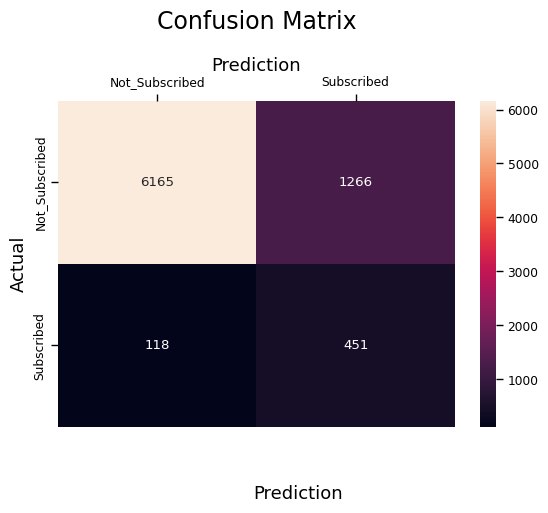

In [269]:
lreg_rus_y_pred = lreg_rus.predict(X_test)

lreg_rus_cm = confusion_matrix(y_test, lreg_rus_y_pred)

target_names = ['Not_Subscribed', 'Subscribed']
print(classification_report(y_test, lreg_rus_y_pred, target_names=target_names))

sns.heatmap(lreg_rus_cm,
            annot=True,
            fmt='g',
            xticklabels=['Not_Subscribed','Subscribed'],
            yticklabels=['Not_Subscribed','Subscribed'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

After running random undersampler, we can observed the following referencing to Subcribed users:
- lowest precision compared to Oversampling (SMOTE) and base LR model

- recall is high compared to oversampling but low compared to base LR model

- True Subscriber count is 451

- False Positive count is 1266

--------------------------------------------------------

Overall Conlusion comparing Base LR Model, Oversampling (SMOTE), and Undersampling (RandomUnderSampler) - referencing to Subscribed

|     Model    | Accuracy | Precision | Recall | True Subscriber | False Positive |
| -----------  | -------- | --------- | ------ | --------------- | -------------- |
|    Base LR   |   84%    |   27%     | 78%    |       444       |      1189      |
| Oversampling |   89%    |   34%     | 53%    |       301       |       590      |
| Undersampling|   83%    |   26%     | 79%    |       451       |      1266      |


OVERALL, we conclude to proceed with Oversampling using SMOTE because of the following observations:
- Highest Accuracy
- Highest Precision
- Lowest False Positive count

Note: Even though Oversampling has the lowest "True Subscriber", still it has the lowest False Positive which in turn can save a lot of time for the client instead of calling everyone where the model thinks they are subscribers

--------------------------------------------------------

## Secondary Model for Capturing True Subscribers

Building another model that will predict who to call out of ~900 clients from LR + oversampling (smote) base model

Note that we already have done Logistic Regressing - oversampling using SMOTE earlier and we will use the test set from that model for fitting only the ~900 clients to call

In [270]:
test_results = X_test.copy()

In [271]:
#apprehending the y_test valies in the new data fram "test_results"
test_results['actual_subscribed'] = y_test.values 

test_results['predicted_probability'] = lreg_smote.predict_proba(X_test)[:, 1]

#apprehending smote prediction similar to lreg_smote.predict(X_test)
test_results['lr_smote_prediction'] = lreg_smote_y_pred 

In [272]:
print(test_results['lr_smote_prediction'].unique())

print(test_results['lr_smote_prediction'].value_counts())

print(test_results['lr_smote_prediction'].head())

['no' 'yes']
lr_smote_prediction
no     7109
yes     891
Name: count, dtype: int64
4905     no
4342     no
30482    no
34538    no
30242    no
Name: lr_smote_prediction, dtype: object


In [273]:
predicted_positives = test_results[test_results['lr_smote_prediction'] == 'yes'].copy()
print(predicted_positives)

       age  balance  day  duration  campaign  job_blue-collar  \
10951   59        3   17      1199         2            False   
15175   33     1904   17      1584         2            False   
20976   58     2553   14       366         2            False   
35861   56       -9    8       728         1             True   
24506   42      970   17       725         1            False   
...    ...      ...  ...       ...       ...              ...   
21124   60      491   14       503         4            False   
26961   47        0   21       591         1            False   
24575   50      202   17       148         1            False   
10241   40     1248   11      1290         2            False   
29684   44      284    3       167         4             True   

       job_entrepreneur  job_housemaid  job_management  job_retired  ...  \
10951             False          False           False         True  ...   
15175             False          False           False        False

From here, we have confirmed that we have used that test set from the Logistic Regression with SMOTE as total rows now is 891 compared to the original dataset which is 8000

NOTE: Be careful with "predicted_positives = test_results[test_results['lr_smote_prediction'] == 'yes']" as from my experience, I did take time in resolving the issue where predictive_positives is always resulting to 0 as I didn't see that it was either yes or no output instead of 1 or 0.

In [274]:
# Defining the updated dataset from the additional variable we have generated from the oversampling
X_refine = predicted_positives.drop(columns=['actual_subscribed', 'lr_smote_prediction'])
y_refine = predicted_positives['actual_subscribed']

In [275]:
# Re-train-test-split the refined dataset for the 2nd model
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_refine, y_refine, test_size=0.25, random_state=seed)

In [276]:
lreg_ref = LogisticRegression(class_weight='balanced', random_state=seed)
lreg_ref.fit(X_train_new, y_train_new)

LogisticRegression(class_weight='balanced', random_state=6925)

              precision    recall  f1-score   support

          no       0.78      0.70      0.74       139
         yes       0.58      0.68      0.62        84

    accuracy                           0.69       223
   macro avg       0.68      0.69      0.68       223
weighted avg       0.70      0.69      0.69       223



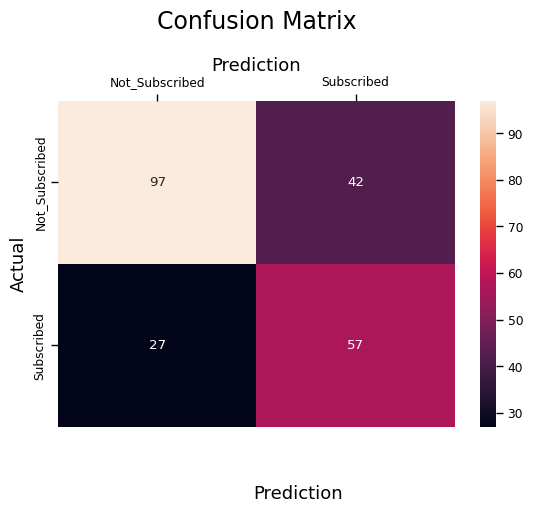

In [277]:
lreg_ref_y_pred = lreg_ref.predict(X_test_new)
print(classification_report(y_test_new, lreg_ref_y_pred))

lreg_ref_cm = confusion_matrix(y_test_new, lreg_ref_y_pred)

target_names = ['Not_Subscribed', 'Subscribed']

sns.heatmap(lreg_ref_cm,
            annot=True,
            fmt='g',
            xticklabels=['Not_Subscribed','Subscribed'],
            yticklabels=['Not_Subscribed','Subscribed'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

## Target Selection Using Probability Thresholds

In this section, the predicted probabilities from the logistic regression model are used to prioritize users based on their likelihood of being true subscribers. By calculating the 25th and 75th percentiles of the predicted probabilities, two target groups are formed:

- Top 75% group (≥ 25th percentile): A broader set of users likely to subscribe.
- Top 25% group (≥ 75th percentile): A more focused list of high-confidence users.

In [278]:
X_final = predicted_positives.drop(columns=['actual_subscribed', 'lr_smote_prediction'])
probs = lreg_ref.predict_proba(X_final)[:, 1] 

#creates a new column in predicted_positives dataframe named "predicted_probability" with the same value generated in probs
predicted_positives['predicted_probability'] = probs 

In [279]:
print(len(predicted_positives))
print(len(probs))

891
891


In [280]:
# Select the top 75% of clients with the highest predicted probabilities of a positive outcome and sort them in descending order to 
# prioritize them for action (e.g., marketing call, outreach).

threshold_75 = predicted_positives['predicted_probability'].quantile(0.25)
clients_to_call_75 = predicted_positives[predicted_positives['predicted_probability'] >= threshold_75].copy()
clients_to_call_75 = clients_to_call_75.sort_values(by='predicted_probability', ascending=False)

In [281]:
clients_to_call_75.to_csv('clients_to_call_75.csv', index=False)
print(f"Exported {len(clients_to_call_75)} clients to call.")

Exported 668 clients to call.


In [282]:
print(f"Threshold for top 75%: {threshold_75:.4f}")

Threshold for top 75%: 0.2732


In [283]:
# Count actual subscribers among the 668 selected
num_actual_subscribers_75 = clients_to_call_75[clients_to_call_75['actual_subscribed'] == "yes"].shape[0]
print(f"Actual subscribers among 668 clients: {num_actual_subscribers_75}")

Actual subscribers among 668 clients: 288


In [284]:
# Total call duration for selected 668 clients
total_call_duration_668_75 = clients_to_call_75['duration'].sum()
print(f"Total call duration for 668 clients: {total_call_duration_668_75 / 3600:.2f} hours")

# Total call duration for all clients
total_call_duration_all = df['duration'].sum()
print(f"Total call duration for all clients: {total_call_duration_all / 3600:.2f} hours")

Total call duration for 668 clients: 147.77 hours
Total call duration for all clients: 2831.38 hours


In [285]:
threshold_25 = predicted_positives['predicted_probability'].quantile(0.75)
clients_to_call_25 = predicted_positives[predicted_positives['predicted_probability'] >= threshold_25].copy()
clients_to_call_25 = clients_to_call_25.sort_values(by='predicted_probability', ascending=False)

In [286]:
clients_to_call_25.to_csv('clients_to_call_25.csv', index=False)
print(f"Exported {len(clients_to_call_25)} clients to call.")

Exported 223 clients to call.


In [287]:
# Total call duration for selected 223 clients
total_call_duration_223_25 = clients_to_call_25['duration'].sum()
print(f"Total call duration for 223 clients: {total_call_duration_223_25 / 3600:.2f} hours")

# Total call duration for all clients
total_call_duration_all = df['duration'].sum()
print(f"Total call duration for all clients: {total_call_duration_all / 3600:.2f} hour")

Total call duration for 223 clients: 73.58 hours
Total call duration for all clients: 2831.38 hour


----------

CONCLUSION

- There are total of 891 clients that are found to be subscribers (both True Positives and False Positives)
- Exported two (2) options for the client -- 75th quartile and 25th quartile
- The two (2) options to be provided to client helps them decide how to allocate manpower in calling the users
- Duration of call in hours is also provided for reference

-----------

# Add-On Task

- Filtering data via SQL using duckDB
- Clustering 

> K-means

> Hierarchical

- Dimensionality Reduction for Visualization

> PCA

> TSNE

> Umap            

## SQL using DuckDB

In [288]:
!pip install duckdb

In [289]:
import duckdb

In [290]:
# Create an in-memory DuckDB connection
con = duckdb.connect()

In [291]:
# Register the DataFrame as a DuckDB table
con.register('term_deposit', df)

In [292]:
#check for column names and its data
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,subscribed
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [293]:
#filtering data only that subscribed column is showing "yes"
result = con.execute("SELECT * FROM term_deposit WHERE subscribed = 'yes'").df()

In [294]:
#printing the data from result -- similar to df.head()
result.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,subscribed
0,59,admin,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,yes
1,56,admin,married,secondary,no,45,no,no,unknown,5,may,1467,1,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,yes
4,54,admin,married,tertiary,no,184,no,no,unknown,5,may,673,2,yes


In [295]:
result.dtypes

age            int64
job           object
marital       object
education     object
default       object
balance        int64
housing       object
loan          object
contact       object
day            int64
month         object
duration       int64
campaign       int64
subscribed    object
dtype: object

## CLUSTERING - K-Means

In [296]:
X_clustering = result.select_dtypes(include='number')

In [297]:
print(X_clustering)

      age  balance  day  duration  campaign
0      59     2343    5      1042         1
1      56       45    5      1467         1
2      41     1270    5      1389         1
3      55     2476    5       579         1
4      54      184    5       673         2
...   ...      ...  ...       ...       ...
2891   29      637    3       340         1
2892   55     2383    3       591         2
2893   26     1231    3       385         2
2894   30     3340    3       238         3
2895   54      200    3       170         1

[2896 rows x 5 columns]


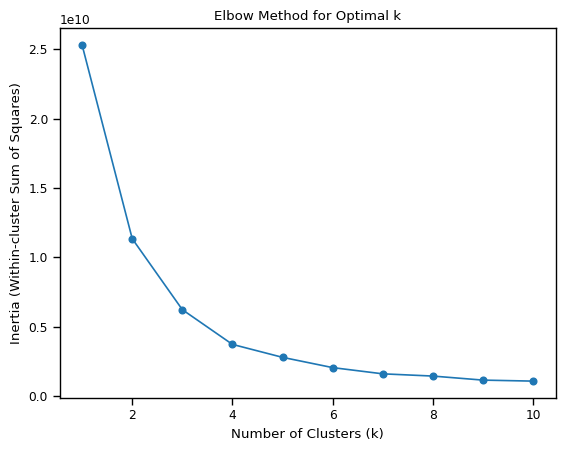

In [298]:
from sklearn.cluster import KMeans

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(X_clustering)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.show()

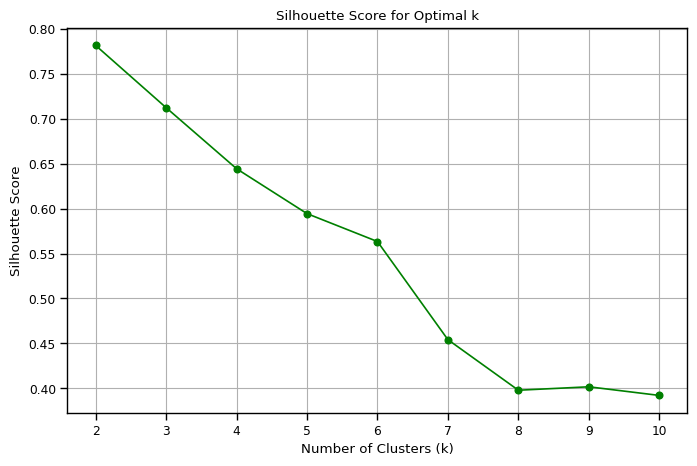

In [299]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=seed)
    labels = kmeans.fit_predict(X_clustering)
    score = silhouette_score(X_clustering, labels)
    silhouette_scores.append(score)

# Plot the scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True)
plt.show()

In [300]:
kmeans = KMeans(n_clusters=2, random_state=seed)
labels = kmeans.fit_predict(X_clustering)
result['kmeans_cluster'] = labels

In [301]:
result['kmeans_cluster'].value_counts()

kmeans_cluster
0    2689
1     207
Name: count, dtype: int64

In [302]:
# Importing libraries -  Dimensionality Reduction for Visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### PCA Visualization for K-Means Clustering

In [303]:
pca = PCA(n_components=None)
X_pca = pca.fit_transform(X_clustering)

In [304]:
result['pca1'] = X_pca[:, 0]
result['pca2'] = X_pca[:, 1]

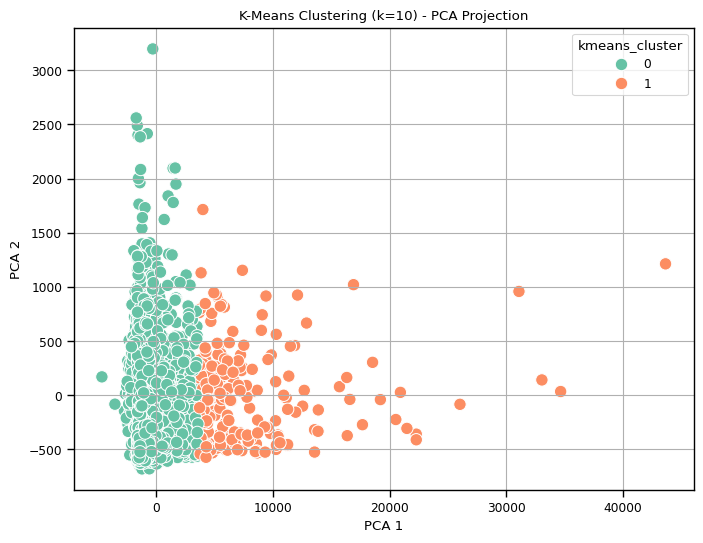

In [305]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=result, x='pca1', y='pca2', hue='kmeans_cluster', palette='Set2', s=80)
plt.title(f'K-Means Clustering (k={k}) - PCA Projection')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

In [306]:
cluster_summary = result.groupby('kmeans_cluster').mean(numeric_only=True)
print(cluster_summary)

                 age  balance   day  duration  campaign    pca1  pca2
kmeans_cluster                                                       
0              39.61   979.31 15.79    686.08      2.42 -609.19 -0.69
1              42.90  9502.01 16.25    642.44      2.40 7913.61  8.93


### TSNE Visualization for K-Means

In [307]:
tsne = TSNE(n_components=2, random_state=seed, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_clustering)

In [308]:
result['tsne1'] = X_tsne[:, 0]
result['tsne2'] = X_tsne[:, 1]

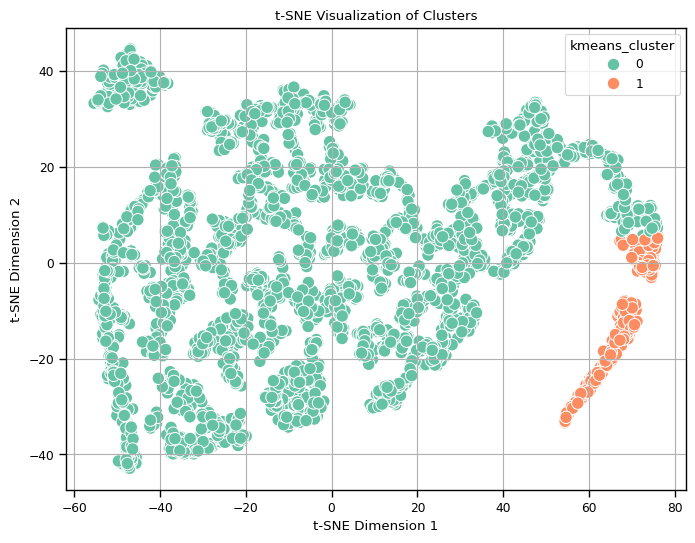

In [309]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=result, x='tsne1', y='tsne2', hue='kmeans_cluster', palette='Set2', s=80)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

### UMAP Visualization for K-Means Clustering

In [310]:
!pip install umap-learn

In [311]:
import umap

In [312]:
reducer = umap.UMAP(n_components=2, random_state=seed, n_neighbors=15, min_dist=0.1)

# Fit and transform your data
X_umap = reducer.fit_transform(X_clustering)  # or X_clustering if not scaled

In [313]:
result['umap1'] = X_umap[:, 0]
result['umap2'] = X_umap[:, 1]

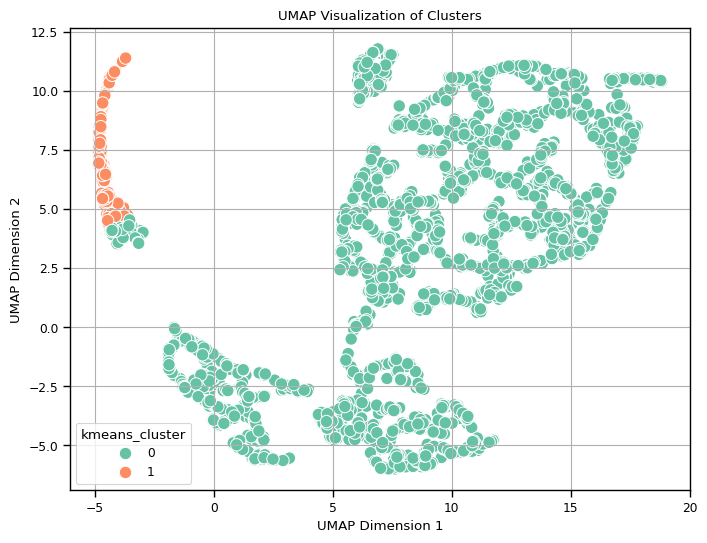

In [314]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=result, x='umap1', y='umap2', hue='kmeans_cluster', palette='Set2', s=80)
plt.title('UMAP Visualization of Clusters')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)
plt.show()

## Hierarchical Clustering

In [315]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

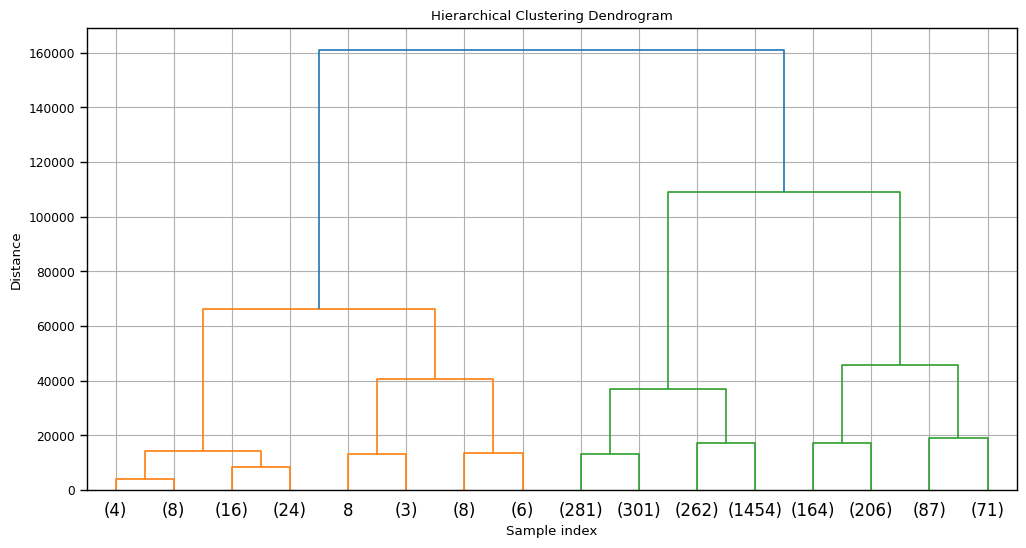

In [316]:
linked = linkage(X_clustering, method='ward')  # 'ward' minimizes variance within clusters

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=3)  # show only top levels for readability
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

In [317]:
# Perform hierarchical agglomerative clustering with 2 clusters
# using Ward linkage (minimizes variance within clusters).
# This assigns each sample in X_clustering a cluster label (0 or 1).

agglo = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
labels_hier = agglo.fit_predict(X_clustering)

In [318]:
result['hier_cluster'] = labels_hier

In [319]:
result.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,subscribed,kmeans_cluster,pca1,pca2,tsne1,tsne2,umap1,umap2,hier_cluster
0,59,admin,married,secondary,no,2343,yes,no,unknown,5,...,1,yes,0,752.25,363.75,32.21,13.52,3.03,-2.64,0
1,56,admin,married,secondary,no,45,no,no,unknown,5,...,1,yes,0,-1548.36,774.38,-8.42,32.37,5.60,4.52,0
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,...,1,yes,0,-322.90,704.04,11.43,14.76,6.36,0.24,0
3,55,services,married,secondary,no,2476,yes,no,unknown,5,...,1,yes,0,888.14,-98.41,40.27,11.62,1.78,-4.18,0
4,54,admin,married,tertiary,no,184,no,no,unknown,5,...,2,yes,0,-1404.40,-18.73,-34.79,-0.50,11.26,7.97,0


### PCA Visualization for Hierarchical Clustering

In [320]:
pca = PCA(n_components=None)
X_pca = pca.fit_transform(X_clustering)

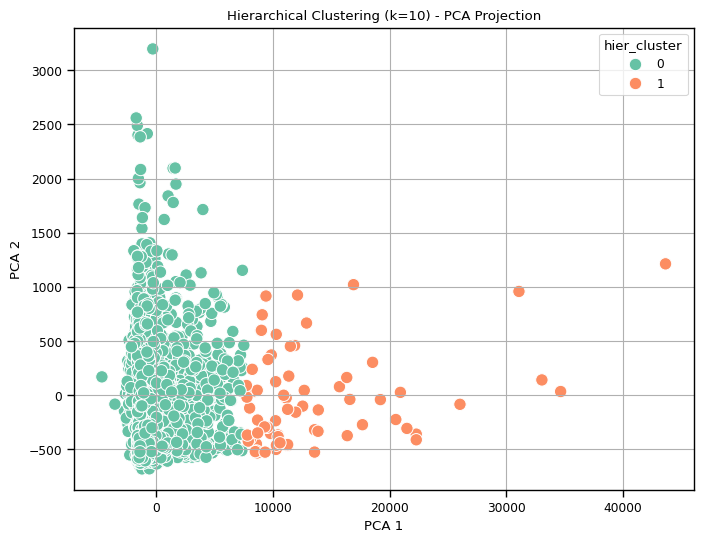

In [321]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=result, x='pca1', y='pca2', hue='hier_cluster', palette='Set2', s=80)
plt.title(f'Hierarchical Clustering (k={k}) - PCA Projection')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

### TSNE Visualization for Heirarchical Clustering

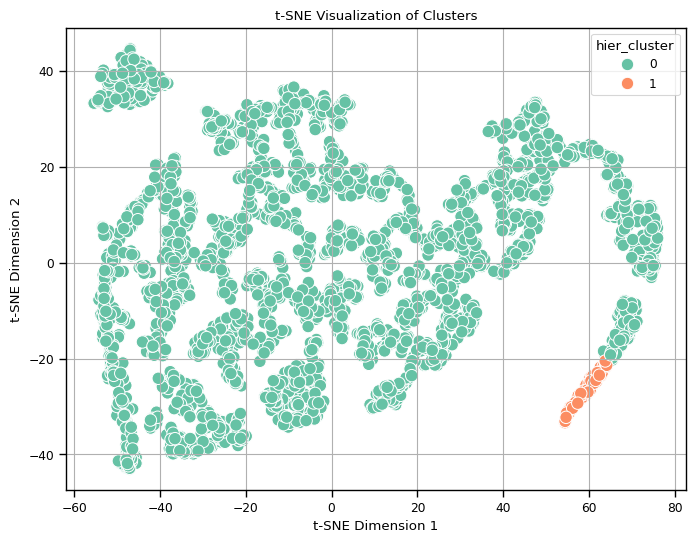

In [322]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=result, x='tsne1', y='tsne2', hue='hier_cluster', palette='Set2', s=80)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

### UMAP Visualization for Heirarchical Clustering

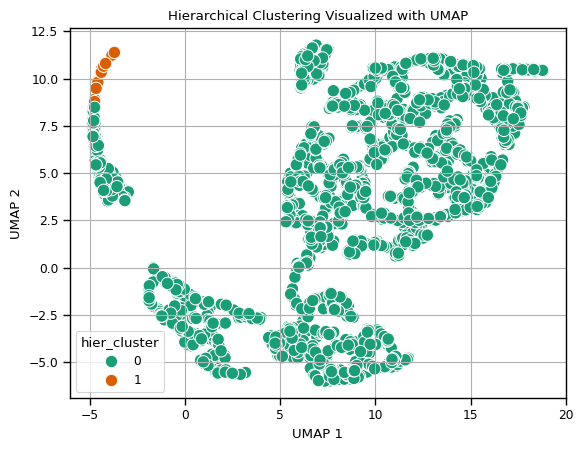

In [323]:
sns.scatterplot(data=result, x='umap1', y='umap2', hue='hier_cluster', palette='Dark2', s=80)
plt.title('Hierarchical Clustering Visualized with UMAP')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()

In [324]:
# Creates a cross-tabulation table (confusion matrix-style) comparing the clustering labels assigned by:
# - kmeans_cluster (from K-Means)
# - hier_cluster (from Hierarchical Clustering)

pd.crosstab(result['kmeans_cluster'], result['hier_cluster'])

hier_cluster,0,1
kmeans_cluster,,
0,2689,0
1,137,70


-----------------

Observation from Clustering:

- Strong Agreement for Cluster 0:

> All 2689 points in kmeans_cluster 0 were also assigned to hier_cluster 0.

> This indicates strong alignment between K-Means and Hierarchical Clustering for this group.

- Mixed Assignment in Cluster 1:

> In kmeans_cluster 1, 137 points went to hier_cluster 0 and 70 points to hier_cluster 1.

> This shows some disagreement in how the two algorithms interpret the structure of kmeans_cluster 1.

Overall comparison:
    
- The majority of data points (2689) are consistently clustered by both methods.

- The discrepancy lies in the smaller cluster (kmeans_cluster 1), suggesting that hierarchical clustering may be splitting this group differently — possibly detecting a substructure K-Means missed.

- K-Means tends to form equal-sized spherical clusters, while hierarchical clustering (with Ward linkage) is more flexible with shapes and sizes.

---------------------------

# Conclusion Summary

## Objective

The main objective of this project was to identify clients who are most likely to subscribe to a term deposit product, enabling the business to prioritize follow-up calls effectively. Using insights from exploratory data analysis (EDA) and machine learning techniques, the goal was to develop a data-driven recommendation that supports efficient client targeting.

## Approach Summary

The project began with univariate and bivariate analysis to explore and understand the structure, distribution, and relationships within the dataset. Initially, a **train-test-validation split** was applied to test the modeling process and evaluate generalization before using the actual dataset. Once validated, the full dataset was split into training and test sets for the final modeling phase.

Multiple machine learning models were tested to determine the most effective approach, with **Logistic Regression** emerging as the most suitable due to its balance of performance, interpretability, and alignment with the business objective. Given the imbalanced nature of the dataset, both **oversampling and undersampling techniques** were evaluated. Oversampling proved to be more effective, producing better results in model performance and stability.

The final logistic regression model (with oversampling applied) was retrained to identify **true subscribers**. Predicted probabilities were then used to extract the 25th and 75th percentile thresholds. These thresholds were applied to segment high-confidence clients, and the resulting lists were exported to CSV files for client action.

## Key Findings

- Out of approximately **40,000 total clients**, the model identified **891 clients** as potential **true subscribers** (True Positives + False Positives).
- Since not all identified clients are guaranteed to subscribe, **probability thresholds** were used to provide more refined options:
  - **75th percentile**: 668 clients (higher coverage, moderate confidence)
  - **25th percentile**: 223 clients (smaller group, higher confidence)
- Estimated **total call duration** for contacting all 40,000 clients is **2,831.38 hours**, whereas targeting the 25th percentile group would require only **147.77 hours**, and the 75th percentile group just **73.58 hours**—a significant reduction in resource allocation.

## Business Insights

- A relatively **small segment of clients drives most of the predicted positive outcomes**, supporting the need for focused targeting rather than mass outreach.
- By using **predicted probabilities** and **quantile-based segmentation**, the business can optimize manpower and reduce call time while still maintaining a strong likelihood of client conversion.
- **Efficiency gains** are significant when shifting from full outreach to targeted calling—up to **95% reduction in hours** if focusing only on the top 25% most likely to subscribe.
- The model provides not just predictions but also **actionable insights**, enabling better planning of outreach campaigns, scheduling, and workforce deployment.

## Recommendation

- Prioritize follow-up calls to the **top 223 clients (25th percentile)** with the highest predicted probabilities. This segment offers the highest confidence and requires only **73.58 hours** of total call time.
- If the business is willing to extend efforts slightly, the **top 668 clients (75th percentile and above)** can be included, requiring **147.77 hours** of total call time—still a substantial reduction from calling all clients.
- Avoid full-scale outreach to all 40,000 clients, as it would consume **2,831.38 hours**, with significantly lower return efficiency.
- Continue to refine the model over time with updated data, including actual subscription outcomes, to improve precision and reduce false positives in future campaigns.